In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R32_bmimPF6_PR import configuration
data = pd.read_csv('R32IL.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)


# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_bmimPF6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
    DOF_final = degrees_of_freedom(m)
    print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0


In [4]:
print(P)
print(data["pressure"])
print(R32_x)
print(data["x_R32"])

[  16830.66646781   88475.54909492  237065.75076531  395102.35111414
  543441.38085109  661341.32069316  904199.63918807   22396.07689541
   96299.30668337  248845.33312172  402706.32879228  545392.54795497
  687263.77123061  828563.32984252  975207.80393709   13436.2979539
  107298.4494755   263572.62031739  414466.08609037  561764.98559345
  707611.17993125  850670.38209977  989684.3246189    11017.69537369
  107522.3659888   263544.10988184  416618.20894487  565358.93575383
  715360.74884183  854305.81521172 1005081.28411991]
0       9800
1      99600
2     249700
3     399600
4     549700
5     699600
6     849500
7       9700
8      99500
9     249700
10    399800
11    549700
12    699500
13    850100
14    999900
15      9900
16     99500
17    249600
18    399500
19    549700
20    699600
21    849600
22    999600
23      9900
24     99700
25    249500
26    399400
27    549800
28    699700
29    849600
30    999900
Name: pressure, dtype: int64
[0.0206 0.106  0.271  0.428  0.55

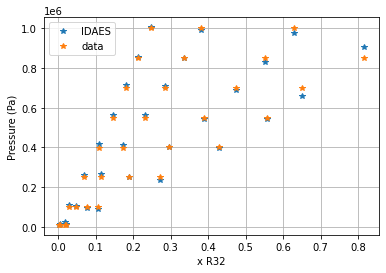

In [5]:
plt.plot(R32_x,P,"*",label="IDAES")  
plt.plot(data["x_R32"],data["pressure"],"*",label="data")  

plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -22.701 : False : (None, None)
    Pressure Change :  5181.3 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.13298       0.86702  
    mole_frac_comp bmimPF6    0.65200   1.0000e-08       0.75200  
    mole_frac_comp R32        0.34800       1.0000       0.24800  
    temperature                348.20       348.20        348.20  
    pressure               9.9990e+05   1.0051e+06    1.0051e+06  
